In [132]:
import numpy as np
import pandas as pd

from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

import math
import time
import json
import re

from matplotlib import pyplot as plt
import seaborn as sns

plt.style.use("seaborn-v0_8")
%matplotlib inline

In [102]:
train_df = pd.read_csv('/kaggle/input/ensembles-competition/train_contest.csv')
prediction_df = pd.read_csv('/kaggle/input/ensembles-competition/for_prediction.csv')

y = train_df['mean_salary']
ID_column = prediction_df['Id']

X = train_df.drop('mean_salary', axis=1)
X_test = prediction_df.drop('Id', axis=1)

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
X.head()

,premium,name,department,has_test,response_letter_required,area,type,address,response_url,sort_point_distance,...,working_days,working_time_intervals,working_time_modes,accept_temporary,description,experience,key_skills,specializations,region,immediate_redirect_url
0,False,Агент по недвижимости,NaN,False,False,"{'id': '2', 'name': 'Санкт-Петербург', 'url': ...","{'id': 'open', 'name': 'Открытая'}","{'city': 'Санкт-Петербург', 'street': 'Невский...",NaN,NaN,...,[],[],[],False,"<p>Мы ищем людей, которым не достаточно того, ...","{'id': 'noExperience', 'name': 'Нет опыта'}","[{'name': 'Жилая недвижимость'}, {'name': 'Акт...","[{'id': '20.20', 'name': 'Агент', 'profarea_id...",Санкт-Петербург,NaN
1,False,IT-специалист/ техник,NaN,False,False,"{'id': '1130', 'name': 'Братск', 'url': 'https...","{'id': 'open', 'name': 'Открытая'}",NaN,NaN,NaN,...,[],[],[],False,<ul> </ul> <p><em><strong>Навыки</strong></em>...,"{'id': 'between1And3', 'name': 'От 1 года до 3...",[],"[{'id': '1.172', 'name': 'Начальный уровень, М...",Иркутская область,NaN
2,False,Старший/ведущий инженер-программист,NaN,False,False,"{'id': '76', 'name': 'Ростов-на-Дону', 'url': ...","{'id': 'open', 'name': 'Открытая'}","{'city': 'Ростов-на-Дону', 'street': '60К-9, 1...",NaN,NaN,...,[],[],[],False,<strong>Обязанности:</strong> <ul> <li>Разрабо...,"{'id': 'between1And3', 'name': 'От 1 года до 3...","[{'name': 'Linux'}, {'name': 'Bash'}, {'name':...","[{'id': '1.221', 'name': 'Программирование, Ра...",Ростовская область,NaN
3,False,Эксперт / методист приемной комиссии,NaN,False,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...","{'id': 'open', 'name': 'Открытая'}","{'city': 'Москва', 'street': '1-я Миусская ули...",NaN,NaN,...,[],[],[],False,<p>Департамент информационных технологий РХТУ ...,"{'id': 'between1And3', 'name': 'От 1 года до 3...","[{'name': '1С программирование'}, {'name': 'Об...","[{'id': '3.150', 'name': 'Менеджмент продукта ...",Москва,NaN
4,False,Табельщица/табельщик,NaN,False,False,"{'id': '1613', 'name': 'Энгельс', 'url': 'http...","{'id': 'open', 'name': 'Открытая'}","{'city': None, 'street': None, 'building': Non...",NaN,NaN,...,[],[],[],False,<p><strong>Обязанности:</strong></p> <ul> <li>...,"{'id': 'between1And3', 'name': 'От 1 года до 3...","[{'name': 'Составление отчетности'}, {'name': ...","[{'id': '18.142', 'name': 'Машиностроение', 'p...",Саратовская область,NaN


## Предобработка датасета

In [111]:
X = X.replace({np.nan: None})

Сначала разберемся с признаками, которые представлены в виде JSON объектов: изучим доступные поля и попробуем вытащить из них самую важную информацию

Посмотрим на булевые столбцы и решим, надо ли их удалить

array([[<Axes: title={'center': 'premium'}>,
        <Axes: title={'center': 'has_test'}>],
       [<Axes: title={'center': 'response_letter_required'}>,
        <Axes: title={'center': 'archived'}>],
       [<Axes: title={'center': 'accept_temporary'}>, <Axes: >]],
      dtype=object)

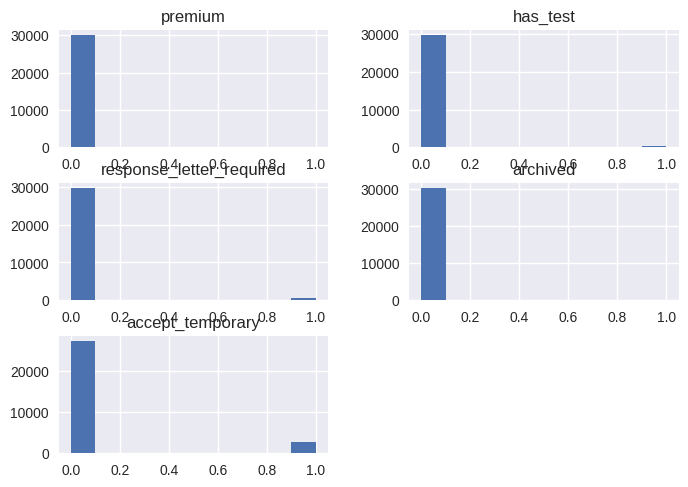

In [6]:
X.select_dtypes(include=['bool']).astype(float).hist()

Да, надо.

Так как в датасете используется описание вакансии, попробую достать эмбеддинги из текстового описания. Использование просто длины описания оказалось неэффективно, а содержимое вакансии может напрямую коллерировать с зарплатой

In [32]:
import fasttext
from huggingface_hub import hf_hub_download

model_path = hf_hub_download("facebook/fasttext-ru-vectors", "model.bin")
fasttext_model = fasttext.load_model(model_path)

model.bin:   0%|          | 0.00/7.26G [00:00<?, ?B/s]

In [41]:
fasttext_model.get_nearest_neighbors("Продажа", k=5)

[(0.7590396404266357, 'продажа'),
 (0.7400502562522888, 'Покупка'),
 (0.6890888214111328, 'Аренда'),
 (0.6885383129119873, '.Продажа'),
 (0.6405532956123352, '-продажа')]

In [112]:
import ast

class DFTransformer:
    def __init__(self, X):
        self.X = X

    def transform(self):
        self.X = self.X.replace({np.nan: None})
        self.__drop_redundant_columns()
        self.__extract_values_from_json()
        self.__apply_text_processing()
        self.__apply_encoding()

    def __drop_redundant_columns(self):
        self.X = self.X.drop(self.X.select_dtypes(include=['bool']).columns, axis=1)
        self.X = self.X.drop([
            'sort_point_distance', 'specializations',
            'name', 'contacts', 'type', 'published_at',
            'relations', 'working_days', 'working_time_intervals',
            'working_time_modes', 'department', 'created_at',
            'address', 'schedule', 'employer', 'insider_interview'
        ], axis=1)

        url_columns = list(filter(lambda x: "url" in x.lower(), self.X.columns))
        self.X = self.X.drop(url_columns, axis=1)

    def __extract_values_from_json(self):
        self.X['experience'] = self.X['experience'].apply(lambda x: self.__select_json_field(x, 'id'))

        self.X['area'] = self.X['area'].apply(lambda x: self.__select_json_field(x, 'name'))
        self.X['area'] = self.X['area'].apply(self.__city_to_federal_district)

    def __apply_text_processing(self):
        self.X['description'] = self.X['description'].apply(lambda x: re.sub('<[^<]+?>', '', str(x)))

        description_embs = pd.DataFrame(self.X['description'].apply(lambda x: fasttext_model[x]).apply(pd.Series))
        description_embs.columns = [f'description_embedding_{i+1}' for i in range(description_embs.shape[1])]

        self.X['key_skills'] = self.X['key_skills'].apply(self.__extract_text_key_skills_col)
        self.X = pd.concat([self.X, description_embs], axis=1)
        
        self.X = self.X.drop(['snippet', 'description', 'region'], axis=1)

    def __apply_encoding(self):
        self.X = pd.get_dummies(self.X, columns=['experience'], dtype=int)
        self.X = pd.get_dummies(self.X, columns=['area'], dtype=int)

    def __extract_text_key_skills_col(self, x):
        skills_list = ast.literal_eval(x)

        return [skill['name'] for skill in skills_list]

    def __select_json_field(self, x, field_name):
        try:
            val = json.loads(x.replace("'", "\""))
            return val[field_name]
        except:
            return x

    def __city_to_federal_district(self, city):
        if any(x in city for x in ['Москва', 'Московская', 'Тверь', 'Тула', 'Рязань', 'Владимир', 'Ярославль',
                                   'Иваново', 'Кострома', 'Белгород', 'Курск', 'Орёл', 'Липецк', 'Тамбов',
                                   'Брянск', 'Новомосковск', 'Пущино', 'Домодедово', 'Подольск', 'Коломна',
                                   'Наро-Фоминск']):
            return 'Центральный ФО'

        elif any(x in city for x in ['Санкт-Петербург', 'Ленинградская', 'Новгород', 'Псков', 'Великие Луки',
                                     'Выборг', 'Кингисепп', 'Сестрорецк', 'Гатчина', 'Всеволожск', 'Кронштадт',
                                     'Сосновый Бор', 'Сланцы', 'Светлогорск']):
            return 'Северо-Западный ФО'

        elif any(x in city for x in ['Ростов-на-Дону', 'Краснодар', 'Волгоград', 'Астрахань', 'Воронеж',
                                     'Новороссийск', 'Сочи', 'Таганрог', 'Новочеркасск', 'Ростов', 'Батайск',
                                     'Азов', 'Шахты', 'Аксай', 'Ейск', 'Каменск-Шахтинский']):
            return 'Южный ФО'

        elif any(x in city for x in ['Казань', 'Нижний Новгород', 'Самара', 'Саратов', 'Ульяновск', 'Пенза',
                                     'Киров', 'Оренбург', 'Уфа', 'Чебоксары', 'Сызрань', 'Тольятти', 'Бугульма',
                                     'Димитровград', 'Новокуйбышевск', 'Самарская', 'Удмуртская']):
            return 'Приволжский ФО'

        elif any(x in city for x in ['Екатеринбург', 'Челябинск', 'Тюмень', 'Курган', 'Ханты-Мансийск',
                                     'Сургут', 'Нижневартовск', 'Ноябрьск', 'Пермь', 'Краснотурьинск',
                                     'Нижний Тагил', 'Каменск-Уральский', 'Серов', 'Красноуральск',
                                     'Березовский', 'Троицк', 'Кушва', 'Невьянск']):
            return 'Уральский ФО'

        elif any(x in city for x in ['Новосибирск', 'Омск', 'Томск', 'Кемерово', 'Красноярск', 'Иркутск',
                                     'Барнаул', 'Бийск', 'Чита', 'Улан-Удэ', 'Братск', 'Норильск', 'Северск',
                                     'Шелехов', 'Усть-Илимск', 'Кызыл', 'Абакан', 'Лесосибирск', 'Мирный']):
            return 'Сибирский ФО'

        elif any(x in city for x in ['Владивосток', 'Хабаровск', 'Благовещенск', 'Южно-Сахалинск', 'Якутск',
                                     'Петропавловск-Камчатский', 'Магадан', 'Чукотка', 'Комсомольск-на-Амуре',
                                     'Амурск', 'Биробиджан', 'Находка', 'Артём', 'Уссурийск', 'Лесозаводск']):
            return 'Дальневосточный ФО'
        else:
            return 'Неизвестный регион'


In [113]:
%%time

df_train_transformer = DFTransformer(X)
df_train_transformer.transform()

X = df_train_transformer.X.copy()

CPU times: user 34.6 s, sys: 258 ms, total: 34.9 s
Wall time: 34.6 s


In [115]:
all_skills = set([skill for sublist in X['key_skills'] for skill in sublist])

In [116]:
for skill in tqdm(all_skills):
    X[skill] = X['key_skills'].apply(lambda x: 1 if skill in x else 0)

X = X.drop(['key_skills'], axis=1)

100%|██████████| 7779/7779 [02:52<00:00, 45.02it/s]


In [117]:
%%time

df_test_transformer = DFTransformer(X_test)
df_test_transformer.transform()

X_test = df_test_transformer.X.copy()

CPU times: user 8.75 s, sys: 19.2 ms, total: 8.77 s
Wall time: 8.76 s


In [118]:
for skill in tqdm(all_skills):
    X_test[skill] = X_test['key_skills'].apply(lambda x: 1 if skill in x else 0)

X_test = X_test.drop(['key_skills'], axis=1)

100%|██████████| 7779/7779 [01:05<00:00, 118.75it/s]


In [119]:
X_test = X_test[X.columns]

In [120]:
import xgboost as xgb

In [121]:
X_train, X_test_lib, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [122]:
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    learning_rate=0.1,
    max_depth=5,
    n_estimators=100,
    seed=42
)

In [134]:
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test_lib)

mean_absolute_error(y_pred, y_test)

38551.68361225841

In [123]:
xgb_model.fit(X, y)

XGBRegressor(alpha=10, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, ...)

In [124]:
weight_rating = xgb_model.get_booster().get_score(importance_type='weight')
weight_rating = dict(sorted(weight_rating.items(), key=lambda item: item[1], reverse=True))

feature_importance_df = pd.DataFrame({'feature_key': weight_rating.keys(), 'feature_importance': weight_rating.values()})
feature_importance_df

,feature_key,feature_importance
0,description_embedding_1,112.0
1,description_embedding_287,39.0
2,description_embedding_3,36.0
3,area_Центральный ФО,33.0
4,description_embedding_69,30.0
...,...,...
457,Телефонные переговоры,1.0
458,Желание зарабатывать,1.0
459,B2C продажи,1.0
460,NoSQL,1.0


In [131]:
feature_importance_df[:10]

,feature_key,feature_importance
0,description_embedding_1,112.0
1,description_embedding_287,39.0
2,description_embedding_3,36.0
3,area_Центральный ФО,33.0
4,description_embedding_69,30.0
5,experience_moreThan6,30.0
6,description_embedding_77,29.0
7,description_embedding_162,29.0
8,description_embedding_2,28.0
9,description_embedding_21,28.0


In [125]:
y_pred = xgb_model.predict(X_test)

In [128]:
submission = pd.DataFrame({ 'Id': ID_column, 'Predicted': y_pred })
submission.to_csv('submission.csv', sep=',', index=False, header=True)